# TensroFlow Quantum でQCL

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

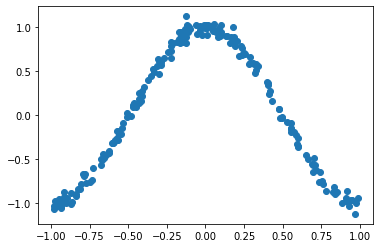

In [2]:
########  パラメータ  #############
nqubit = 3 ## qubitの数
c_depth = 3 ## circuitの深さ
time_step = 0.77  ## ランダムハミルトニアンによる時間発展の経過時間

## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 200

## 学習したい1変数関数
func_to_learn = lambda x: np.cos(x*np.pi)

## 乱数のシード
random_seed = 2
## 乱数発生器の初期化
np.random.seed(random_seed)

#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

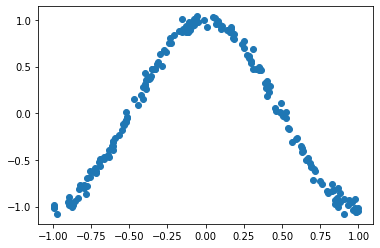

In [3]:
#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

In [4]:
def divide_train_test(data,label, test_ratio=0.3):
    shuffled = np.random.permutation(len(data))
    test_size = int(len(data)*test_ratio)
    test_index = shuffled[:test_size]
    train_index = shuffled[test_size:]
    return data[train_index],label[train_index],data[test_index],label[test_index]

In [5]:
x_train,y_train,x_test,y_test=divide_train_test(x_train,y_train,test_ratio=0.25)

## 入力状態の作成

In [6]:
def convert_to_circuit(x):
    """Encode truncated classical image into quantum datapoint."""
    y = np.arcsin(x)
    z = np.arccos(x**2)
    qubits = cirq.GridQubit.rect(5, 1)
    circuit = cirq.Circuit()
    for i in range(5):
        circuit.append(cirq.ry(y).on(qubits[i]))
        circuit.append(cirq.rz(z).on(qubits[i]))
    return circuit


In [7]:
x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_test]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


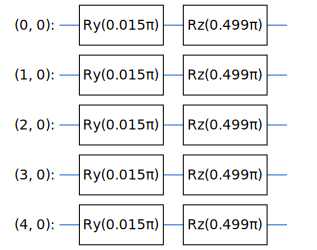

In [8]:
SVGCircuit(x_train_circ[0])

In [9]:
x_train[0],np.arcsin(x_train[0])/np.pi

(0.04826269008976736, 0.015368461591925014)

In [10]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## パラメトリック量子回路（ニューラルネット）の作成

In [11]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
            
    def add_layer_single(self,circuit,gate,prefix):
        symbol = sympy.Symbol(prefix + '-' + str(0))
        circuit.append(gate(symbol).on(self.readout))
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i+1))
            circuit.append(gate(symbol).on(qubit))
    
    def add_entangler(self,circuit,len_qubit):
        circuit.append(cirq.CZ(self.readout,self.data_qubits[0]))
        for i in range(len_qubit-1):
            circuit.append(cirq.CZ(self.data_qubits[i],self.data_qubits[(i+1)%len_qubit]))
        circuit.append(cirq.CZ(self.readout,self.data_qubits[-1]))
            

In [12]:
def create_quantum_model(c_depth=3):
    data_qubits = cirq.GridQubit.rect(5,1)
    readout = cirq.GridQubit(-1,-1)
    circuit = cirq.Circuit()

    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout = readout
    )
    
    for i in range(3):
        builder.add_entangler(circuit,5)
        builder.add_layer(circuit, gate = cirq.XX, prefix='xx'+str(i))
        builder.add_layer(circuit, gate = cirq.ZZ, prefix='zz'+str(i))
        builder.add_layer(circuit, gate = cirq.XX, prefix='xx1'+str(i))
    
    return circuit, cirq.Z(readout)

In [13]:
model_circuit, model_readout = create_quantum_model()

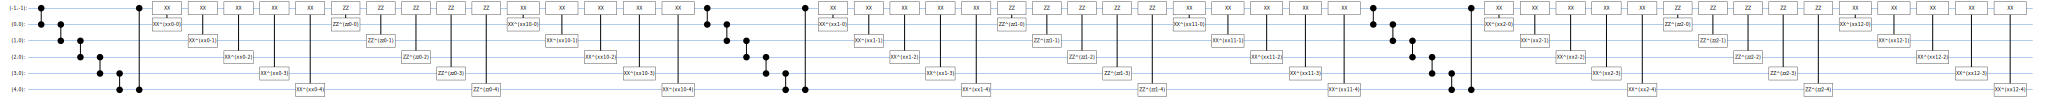

In [14]:
SVGCircuit(model_circuit)

In [15]:
model_readout

cirq.Z.on(cirq.GridQubit(-1, -1))

In [16]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [17]:
model.compile(
    loss=tf.keras.losses.mse,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae'])

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 45        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
EPOCHS = 100
BATCH_SIZE = 50

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc, y_train,
      batch_size=25,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc,y_test)
)

Train on 150 samples, validate on 50 samples
Epoch 1/100
150/150 [==============================] - 4s 29ms/sample - loss: 0.4203 - mae: 0.5814 - val_loss: 0.4318 - val_mae: 0.5934
Epoch 2/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.3745 - mae: 0.5482 - val_loss: 0.3909 - val_mae: 0.5628
Epoch 3/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.3381 - mae: 0.5168 - val_loss: 0.3569 - val_mae: 0.5366
Epoch 4/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.3100 - mae: 0.4923 - val_loss: 0.3286 - val_mae: 0.5129
Epoch 5/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.2851 - mae: 0.4702 - val_loss: 0.3032 - val_mae: 0.4920
Epoch 6/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.2635 - mae: 0.4512 - val_loss: 0.2806 - val_mae: 0.4735
Epoch 7/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.2443 - mae: 0.4346 - val_loss: 0.2612 - val_mae: 0.4571
Epo

150/150 [==============================] - 3s 17ms/sample - loss: 0.0882 - mae: 0.2655 - val_loss: 0.0915 - val_mae: 0.2745
Epoch 61/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.0874 - mae: 0.2644 - val_loss: 0.0905 - val_mae: 0.2728
Epoch 62/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.0864 - mae: 0.2630 - val_loss: 0.0893 - val_mae: 0.2713
Epoch 63/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.0855 - mae: 0.2616 - val_loss: 0.0884 - val_mae: 0.2697
Epoch 64/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.0846 - mae: 0.2603 - val_loss: 0.0873 - val_mae: 0.2682
Epoch 65/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.0838 - mae: 0.2589 - val_loss: 0.0863 - val_mae: 0.2667
Epoch 66/100
150/150 [==============================] - 3s 17ms/sample - loss: 0.0829 - mae: 0.2576 - val_loss: 0.0853 - val_mae: 0.2651
Epoch 67/100
150/150 [==============================] 

In [254]:
model.evaluate(x_test_tfcirc,y_test)

50/50 [==============================] - 0s 3ms/sample - loss: 0.0967 - mae: 0.2768


[0.09673620641231537, 0.27678412]

In [280]:
y_pred = model.predict(x_test_tfcirc)

In [281]:
x_test.shape

(50,)

In [282]:
y_pred.shape

(50, 1)

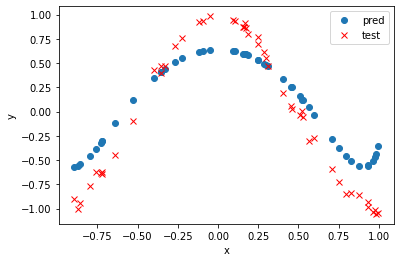

In [285]:
plt.plot(x_test,y_pred,"o",label="pred")
plt.plot(x_test,y_test,"xr",label="test")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
#plt.show()
plt.savefig('fig1.png')